In [25]:
import numpy as np 
import pandas as pd 
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import os
from sklearn import tree
import matplotlib.pylab as plt 
import seaborn as sns

Data Preprocessing

In [3]:
def adjust_df(df, label = 0):
    """
    Helper function that readjusts fourier transform data into a format that 
    sklearn can use to fit/train models

    Parameters: df , label (0 if control, 1 if alzhiemers)
    Output: df_restructured
    """
    df_melted = pd.melt(df, id_vars=['freq'], var_name='subject_freq', value_name='power')

    # Extract the subject and frequency type (e.g., Fp1, Fp2, F3) from the 'subject_freq' column
    df_melted[['subject', 'freq_type']] = df_melted['subject_freq'].str.extract(r'(sub-[^-\s]+)-([A-Za-z0-9]+)')

    # Create a new column that combines frequency type and frequency value in the desired format
    df_melted['freq_column'] = df_melted['freq_type'] + '@freq=' + df_melted['freq'].astype(str)

    # Pivot the dataframe so that each subject has its own row, and each frequency type at each frequency value becomes a column
    df_pivoted = df_melted.pivot_table(index='subject', columns='freq_column', values='power', aggfunc='first')

    # Flatten the multi-level columns to make them more readable
    df_pivoted.columns = [f'{col}' for col in df_pivoted.columns]

    # Reset the index to make 'subject' a column instead of the index
    df_pivoted.reset_index(inplace=True)

    # add label as new column
    df_pivoted["label"] = [label] * df_pivoted.shape[0]

    # drop subject column (subject identifier)
    df_pivoted = df_pivoted.drop(columns=['subject'])

    return df_pivoted

In [4]:
# load in data #
def time_to_fft(df, Fs=500):
    freqs = np.fft.fftfreq(df.shape[0], 1/Fs)
    fft_df = pd.DataFrame({'freq': list(filter(lambda x: x > 0, freqs))})

    def pandas_fft(x):
        temp_fft = np.fft.fft(x)
        temp_fft = temp_fft[:len(temp_fft)//2]
        temp_fft = np.abs(temp_fft)**2
        return temp_fft

    fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
    return list(filter(lambda x: x > 0, freqs)), fft_df

Fs = 500
T300 = 300
AD_EEG_Data = pd.read_csv(os.path.join("EEG_human","ad_eeg_all.csv"))
Control_EEG_Data = pd.read_csv(os.path.join("EEG_human","control_eeg_all.csv"))

AD_EEG_Data_300 = AD_EEG_Data[AD_EEG_Data['time'] <= T300]
Control_EEG_Data_300 = Control_EEG_Data[Control_EEG_Data['time'] <= T300]

AD_freqs_300, AD_EEG_FFT_df_300 = time_to_fft(AD_EEG_Data_300)
Control_freqs_300, Control_EEG_FFT_df_300 = time_to_fft(Control_EEG_Data_300)

/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_94415/255407513.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_94415/255407513.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  fft_df[df.columns[1:]] = df[df.columns[1:]].apply(pandas_fft)
/var/folders/5p/cl5p40yx1j5ftmq1zjznrg6r0000gn/T/ipykernel_94415/255407513.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the

In [5]:
# Control DF, adjust df for sklearn
Xy_control = adjust_df(Control_EEG_FFT_df_300, label = 0)

# Alzheimers DF, adjust df for sklearn
Xy_ad = adjust_df(AD_EEG_FFT_df_300, label = 1)

# combine 2 df's and separate by X and y 
Xy = pd.concat([Xy_control, Xy_ad], ignore_index=True)
X = Xy.drop('label', axis=1)
y = Xy['label']

# train-test split of data #
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, random_state=42)

In [6]:
Xy.head() # df sanity check

,F3@freq=0.003333311111259258,F3@freq=0.006666622222518516,F3@freq=0.009999933333777775,F3@freq=0.013333244445037033,F3@freq=0.01666655555629629,F3@freq=0.01999986666755555,F3@freq=0.023333177778814808,F3@freq=0.026666488890074065,F3@freq=0.029999800001333322,F3@freq=0.03333311111259258,...,Fp2@freq=99.97266684888767,Fp2@freq=99.97600015999893,Fp2@freq=99.9793334711102,Fp2@freq=99.98266678222144,Fp2@freq=99.9860000933327,Fp2@freq=99.98933340444397,Fp2@freq=99.99266671555523,Fp2@freq=99.99600002666648,Fp2@freq=99.99933333777774,label
0,1.983293e+09,1.880680e+09,2.889015e+09,2.599757e+09,1.410648e+09,1.338514e+09,1.140036e+09,1.573545e+09,1.605568e+09,7.249889e+08,...,607.003276,608.848466,607.241702,606.924111,605.926289,606.711752,606.920359,606.628589,608.253593,0
1,4.365135e+08,6.609890e+08,1.356109e+09,1.977479e+09,2.431410e+09,2.608676e+09,2.356604e+09,1.956890e+09,9.906524e+08,8.412033e+08,...,24.512794,24.468096,24.608516,25.050203,25.253992,25.246752,24.730479,24.357220,24.013568,0
2,1.930322e+09,2.295668e+09,2.930230e+09,2.113042e+09,1.092444e+09,3.834521e+08,7.032531e+07,8.124505e+08,2.126665e+09,3.524241e+09,...,60726.756112,14844.752116,58511.640669,8320.319856,39355.279341,32548.403329,20672.375165,99075.281732,11940.749963,0
3,3.683707e+10,7.019653e+09,6.020994e+10,1.178283e+10,1.726783e+10,1.150395e+11,4.816972e+09,3.382195e+10,4.594713e+10,4.470121e+10,...,55305.208689,89140.226105,143070.847390,165614.531615,52382.126827,34648.374330,16573.150513,139771.481554,2100.081275,0
4,1.215083e+07,1.657793e+07,6.204555e+06,1.531639e+07,1.487432e+07,7.809774e+06,4.420698e+07,5.013753e+07,6.678227e+07,5.942986e+07,...,34.086890,33.740381,33.686998,33.653646,33.783815,33.479375,33.066304,33.656909,33.128498,0


In [7]:
Xy.shape

(65, 225001)

In [8]:
def plot_conf_matrix(y_test, y_pred, model = 'SVM'): 
    cm = confusion_matrix(y_test, y_pred)  # Format: [[TN, FP], [FN, TP]]
    labels = ['True Negative (TN)', 'False Positive (FP)', 'False Negative (FN)', 'True Positive (TP)']
    cm_values = np.array([[cm[0, 0], cm[0, 1]], [cm[1, 0], cm[1, 1]]])

    # Plot heatmap #
    plt.figure(figsize=(6,5))
    sns.heatmap(cm_values, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Predicted 0', 'Predicted 1'], yticklabels=['Actual 0', 'Actual 1'])
    plt.xlabel("Predicted Label")
    plt.ylabel("Actual Label")
    plt.title('{} Confusion Matrix Heatmap'.format(model))
    plt.show()

def scoring_metrics(pipeline, X_test, y_test, model = "SVM"):
    y_pred = pipeline.predict(X_test)
    # SCORING METRICS #
    accuracy = pipeline.score(X_test, y_test)
    print('[{} Performance]'.format(model))
    print(f"Accuracy: {accuracy * 100:.2f}%")
    res_metrics = precision_recall_fscore_support(y_test, y_pred, average='weighted')
    print("WEIGHTED Precision, Recall, F-1 Score:")
    print(res_metrics)
    plot_conf_matrix(y_test, y_pred, model = model)
    return accuracy, res_metrics

# SVM

Pros of SVM: can handle both linear and non-linear data, often achieving high accuracy and robustness, especially with high-dimensional data or smaller datasets

[SVM Performance]
Accuracy: 59.09%
WEIGHTED Precision, Recall, F-1 Score:
(0.775, 0.5909090909090909, 0.5086848635235732, None)


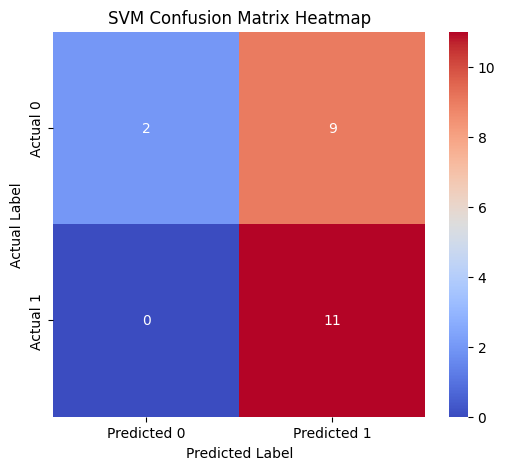

In [60]:
# standarization + svm
pipeline = make_pipeline(StandardScaler(), SVC(kernel = 'rbf' , C = 1, gamma = 'scale'))
pipeline.fit(X_train, y_train)
# gets results
acc, res_metrics = scoring_metrics(pipeline, X_test, y_test)

# PCA + SVM

[PCA + SVM Performance]
Accuracy: 54.55%
WEIGHTED Precision, Recall, F-1 Score:
(0.761904761904762, 0.5454545454545454, 0.42708333333333337, None)


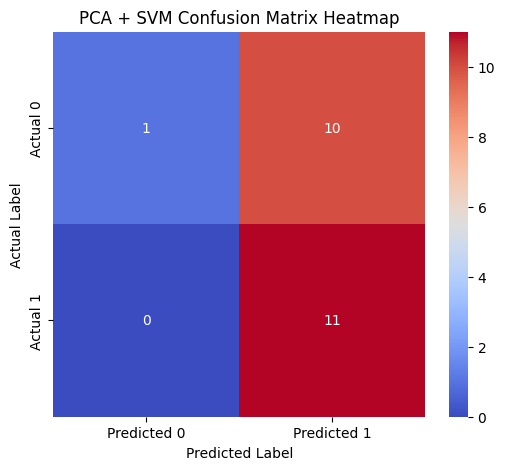

In [61]:
pipeline = make_pipeline(StandardScaler(), PCA(n_components=2), SVC(kernel='linear'))
pipeline.fit(X_train, y_train)

# gets results
acc, res_metrics = scoring_metrics(pipeline, X_test, y_test, model = 'PCA + SVM')

TODO: Try boxing freq's into groups instead of every individual frequency (average)

* may just be an issue of dataset size.

# Naive Bayes

[Naive Bayes Performance]
Accuracy: 54.55%
WEIGHTED Precision, Recall, F-1 Score:
(0.5523809523809523, 0.5454545454545454, 0.5299145299145298, None)


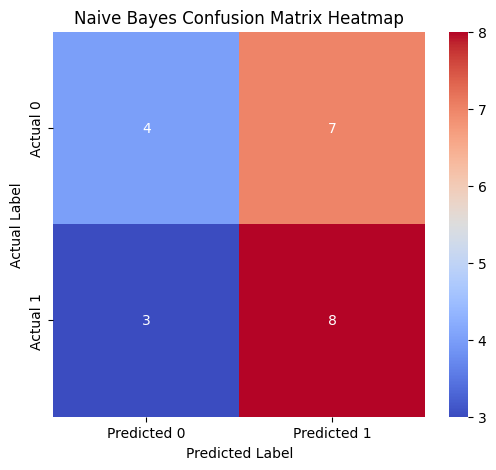

In [21]:

pipeline = make_pipeline(StandardScaler(), GaussianNB())
pipeline.fit(X_train, y_train)
# gets results
acc, res_metrics = scoring_metrics(pipeline, X_test, y_test, model = "Naive Bayes")

# KNN

[KNN Performance]
Accuracy: 59.09%
WEIGHTED Precision, Recall, F-1 Score:
(0.5916666666666667, 0.5909090909090909, 0.5900621118012421, None)


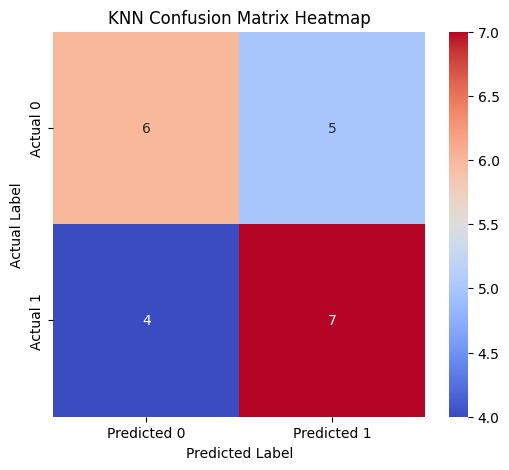

In [20]:
pipeline = make_pipeline(KNeighborsClassifier(n_neighbors=2))
pipeline.fit(X_train, y_train)
# gets results
acc, res_metrics = scoring_metrics(pipeline, X_test, y_test , model = "KNN")

# Decision Tree

[Decision Tree Performance]
Accuracy: 63.64%
WEIGHTED Precision, Recall, F-1 Score:
(0.641025641025641, 0.6363636363636364, 0.6333333333333333, None)


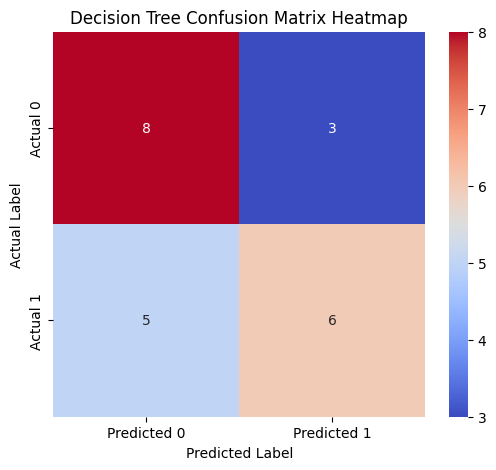

In [23]:
pipeline = make_pipeline(tree.DecisionTreeClassifier())
pipeline.fit(X_train, y_train)
# gets results
acc, res_metrics = scoring_metrics(pipeline, X_test, y_test , model = "Decision Tree")

Find best hyperparameters with grid search